In [1]:
# Importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading feature set into memory and instantiating dataframe

df = pd.read_csv('cleaned_feature_set.csv', index_col = 0)
df

,Solar Energy (kWh),Inverter 1 Energy (kWh),Inverter 2 Energy (kWh),Daylength in decimal hours,Billing Period Duration (Days),Billable kWh,Power Bill Total,Tesla Bill Total,Total Cost
Billing Period End,,,,,,,,,
12/17/2021,590.2,282.2,307.8,251.94,30,1123,195.13,185,380.13
1/19/2022,366.8,77.1,289.7,266.70,32,2046,347.39,185,532.39
2/16/2022,738.0,355.5,382.6,244.05,27,829,146.63,185,331.63
3/21/2022,1280.5,608.4,672.1,320.33,32,160,36.27,185,221.27
4/19/2022,1323.8,641.0,682.7,312.83,28,473,87.90,185,272.90
5/18/2022,1511.0,736.2,775.2,339.47,28,352,61.97,185,246.97
6/17/2022,1546.6,752.0,794.8,369.80,29,882,133.15,185,318.15
7/19/2022,1594.7,775.0,819.6,395.68,31,1410,206.94,185,391.94
8/16/2022,1123.7,547.8,576.0,330.32,27,1448,212.25,185,397.25


In [3]:
# Creating NaNs from 0s in `Inverter 2 Energy (kWh)` column
# and forward-fill them with the mean for measuring error later

df.replace(0, np.nan, inplace=True)
df = df.fillna(df['Inverter 2 Energy (kWh)'].mean())

In [4]:
# Our training set

df[['Inverter 2 Energy (kWh)']].loc[:'9/19/2022']

,Inverter 2 Energy (kWh)
Billing Period End,
12/17/2021,307.8
1/19/2022,289.7
2/16/2022,382.6
3/21/2022,672.1
4/19/2022,682.7
5/18/2022,775.2
6/17/2022,794.8
7/19/2022,819.6
8/16/2022,576.0


In [5]:
# Fitting an auto-regressive integrated moving average (ARIMA) model
# to the training data to make predictions

model = ARIMA(df[['Inverter 2 Energy (kWh)']].loc[:'9/19/2022'],
              order=(1,1,1))
              # seasonal_order=(1, 1, 0, 12),
              # enforce_invertibility=False)

model_fit = model.fit()

# Model summary

print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Inverter 2 Energy (kWh)   No. Observations:                   10
Model:                      ARIMA(1, 1, 1)   Log Likelihood                 -56.722
Date:                     Fri, 03 Feb 2023   AIC                            119.444
Time:                             21:33:44   BIC                            120.035
Sample:                                  0   HQIC                           118.167
                                      - 10                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3952      2.658      0.149      0.882      -4.815       5.605
ma.L1         -0.1366      2.908     -0.047      0.963      -5.835       5.562
sigma2      

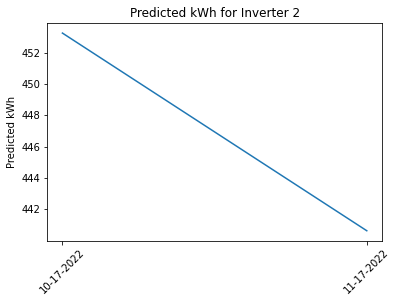

In [6]:
# Making and plotting forecast

forecast = model_fit.forecast(2)

future_months = ['10-17-2022', '11-17-2022']

forecast_df = pd.DataFrame({'Billing Period Ending': future_months,
                            'Predicted kWh': forecast})

plt.ylabel('Predicted kWh')
plt.xticks(rotation = 45)
plt.title('Predicted kWh for Inverter 2')

plt.plot(future_months, forecast)

plt.show()

In [7]:
# Taking a peek at what was predicted

forecast_df

,Billing Period Ending,Predicted kWh
10,10-17-2022,453.261636
11,11-17-2022,440.641025


In [8]:
# That's almost $125 that Tesla owes us for Oct. and Nov. 2022!

forecast_df['Guaranteed Price/kWh'] = 0.13980
forecast_df['Predicted Cost to Us'] = forecast_df['Predicted kWh'] * forecast_df['Guaranteed Price/kWh']

round(forecast_df['Predicted Cost to Us'].sum(), 2)

124.97

**Tesla owes us ~$125 for energy not generated by Inverter 2 in Oct. and Nov. alone, according to my ARIMA model (based on the `Guaranteed Price/kWh` in the [Solar Lease Agreement](https://github.com/nickmccarty/solar-energy-predictor/blob/main/images/tesla-solar-agreement-screenshot.jpg))!**

In [9]:
# Calulating RMSE from predictions

test = df['Inverter 2 Energy (kWh)'][-2:]
predictions = forecast_df['Predicted kWh']

rmse = sqrt(mean_squared_error(test, predictions))

In [10]:
# This suggests that the model is predicting within
# 131 kWh for the month based on the mean that was calculated earlier --
# similar to the performance of our baseline regressor

rmse

131.76985244845517

We can do better, but we'll have to dig a little deeper to figure out how: https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

# Rationale for Model Optimization

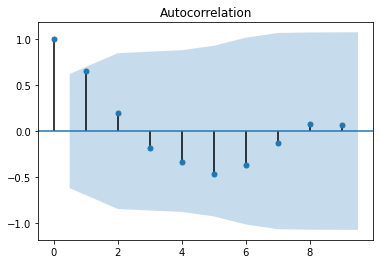

In [11]:
# Plotting the autocorrelation function:
# plots lags on the horizontal and the correlations on vertical axis

df = df[['Inverter 2 Energy (kWh)']].loc[:'9/19/2022']

plot_acf(df)
plt.show()

This autocorrelation plot gives us insights into how we might optimize the parameters `(p, d, q)` of the ARIMA model!

Here we can see that the first lag is significantly out of the limit and the second one is not, so we can select the order of the `p` as 1. 

We can also that none of the lags are out of the significance limit so we can say that the optimal value of our `q` (MA) is 0. This tells us how much moving average is required to remove the autocorrelation from the stationary time series (which was zero in this case). 

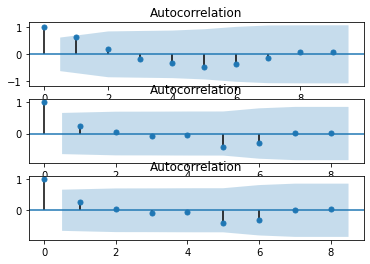

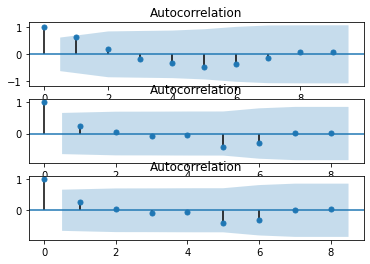

In [12]:
# More autocorrelation plots, kinda ugly

fig, (ax1, ax2, ax3) = plt.subplots(3)

plot_acf(df, ax=ax1)

plot_acf(df.diff().dropna(), ax=ax2)
plot_acf(df.diff().dropna(), ax=ax3)

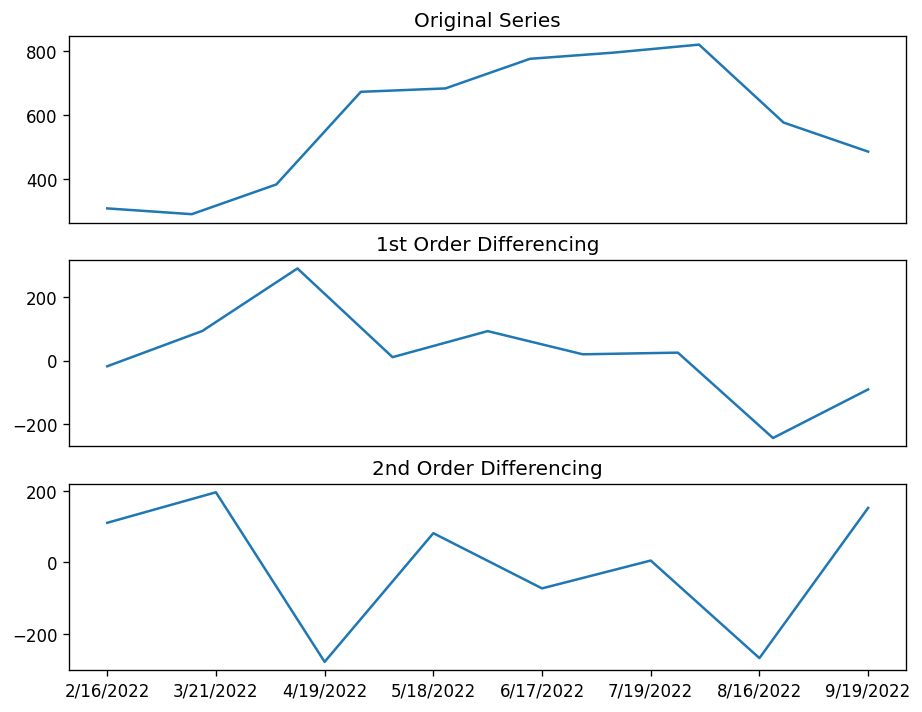

In [13]:
# Showing the noise resulting from first- and second-order differencing

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original series

fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)

# 1st-order differencing

ax2.plot(df.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

# 2nd-order differencing

ax3.plot(df.diff().diff()); ax3.set_title('2nd Order Differencing')

plt.show()

Here we can see how the time series has become stationary. One thing which is noticeable here is in first-order differencing we have less noise in the data while after first order there is an increase in the noise. So we can select first order differencing for our model. We also verified this using an autocorrelation plot. So, `d` = 1, optimally.

In [14]:
result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.481071
p-value: 0.542853
Critical Values:
	1%: -4.473
	5%: -3.290
	10%: -2.772


Here we can see that the p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary, so most of the above was not strictly unnecessary.

But we provided the rationale for an optimized model where `(p,d,q) = (1,1,0)` -- let's see how it performs!

In [15]:
# Fitting optimized ARIMA model

model = ARIMA(df[['Inverter 2 Energy (kWh)']].loc[:'9/19/2022'],
              order=(1,1,0))
              # seasonal_order=(1, 1, 0, 12),
              # enforce_invertibility=False)

model_fit = model.fit()

print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Inverter 2 Energy (kWh)   No. Observations:                   10
Model:                      ARIMA(1, 1, 0)   Log Likelihood                 -56.733
Date:                     Fri, 03 Feb 2023   AIC                            117.465
Time:                             21:33:47   BIC                            117.860
Sample:                                  0   HQIC                           116.614
                                      - 10                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2644      0.602      0.439      0.660      -0.915       1.444
sigma2      1.734e+04   8627.229      2.010      0.044     432.241    3.43e+04
Ljung-Box (L

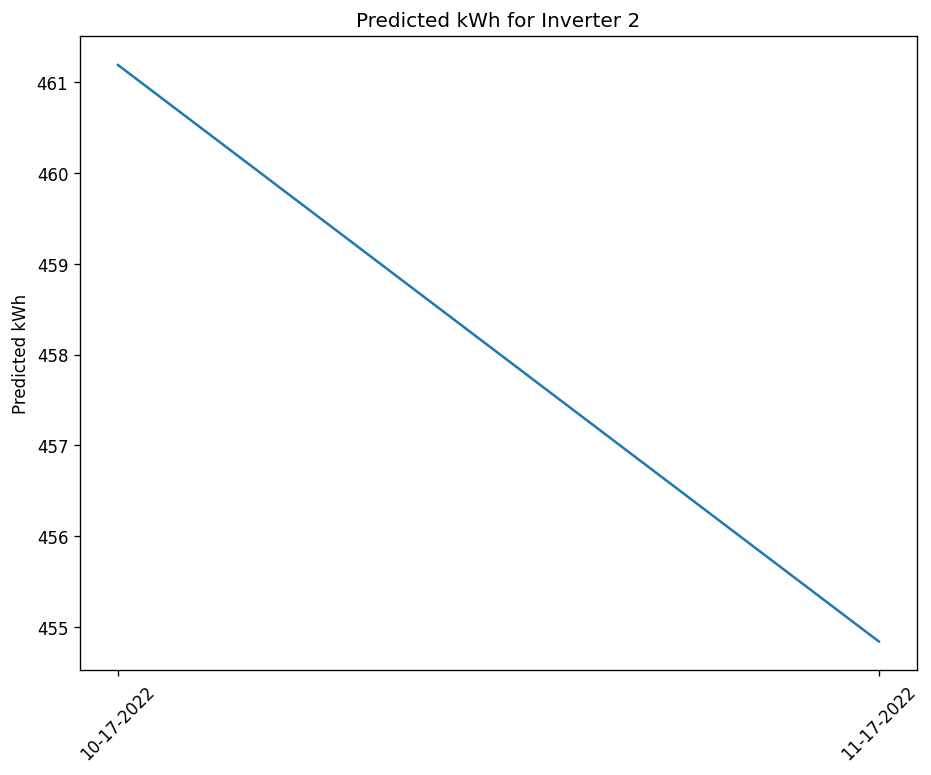

In [16]:
# Forecasting using model

forecast = model_fit.forecast(2)

future_months = ['10-17-2022', '11-17-2022']

forecast_df = pd.DataFrame({'Billing Period Ending': future_months,
                            'Predicted kWh': forecast})

plt.ylabel('Predicted kWh')
plt.xticks(rotation = 45)
plt.title('Predicted kWh for Inverter 2')

plt.plot(future_months, forecast)

plt.show()

In [17]:
# Peeking at forecasts

forecast_df

,Billing Period Ending,Predicted kWh
10,10-17-2022,461.188933
11,11-17-2022,454.839468


In [18]:
# Quantifying what is owed to me by Elon...

forecast_df['Guaranteed Price/kWh'] = 0.13980
forecast_df['Predicted Cost to Us'] = forecast_df['Predicted kWh'] * forecast_df['Guaranteed Price/kWh']

round(forecast_df['Predicted Cost to Us'].sum(), 2)

128.06

In [19]:
# Calulcating error from predictions based on the mean calculated earlier

test = df['Inverter 2 Energy (kWh)'][-2:]
predictions = forecast_df['Predicted kWh']

rmse = sqrt(mean_squared_error(test, predictions))

In [20]:
# Our optimized model can predict within 83 kWh hours what would have been
# generated by inverter 2 in Oct. and Nov. 2022

rmse

83.97423137807371

A noteable improvement - and Tesla appears to owe us $3 more than originally predicted due to power loss from the malfunctioning inverter!

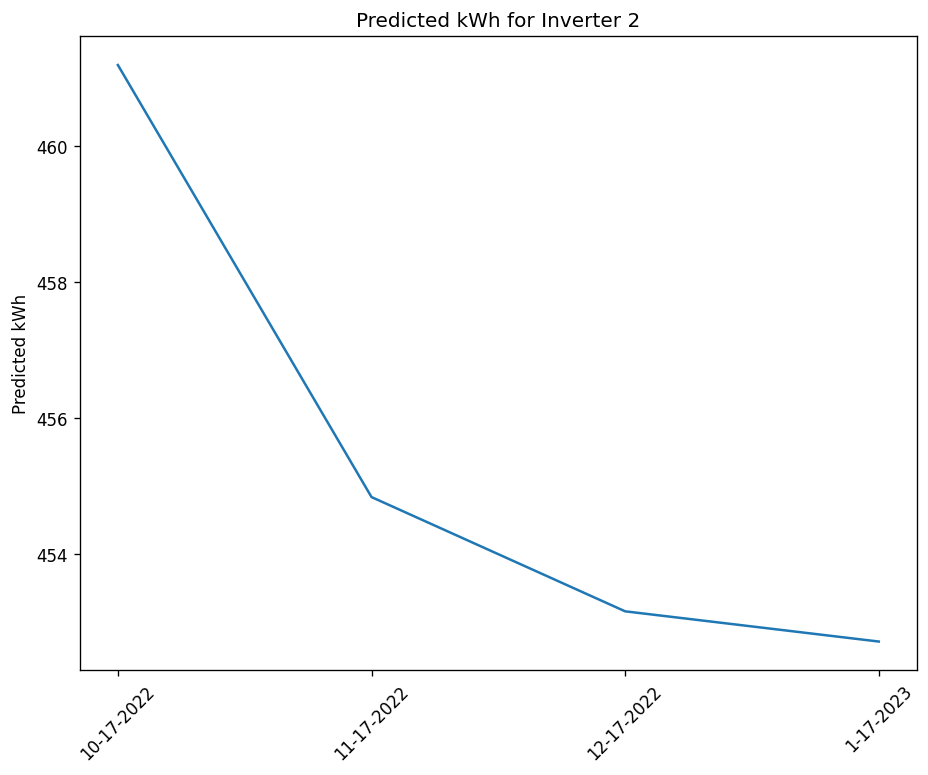

In [21]:
# But what about for December and January?!

forecast = model_fit.forecast(4)

# Assuming regular billing intervals, which we know isn't true

future_months = ['10-17-2022', '11-17-2022', '12-17-2022', '1-17-2023']

forecast_df = pd.DataFrame({'Billing Period Ending': future_months,
                            'Predicted kWh': forecast})

plt.ylabel('Predicted kWh')
plt.xticks(rotation = 45)
plt.title('Predicted kWh for Inverter 2')

plt.plot(future_months, forecast)

plt.show()

In [22]:
forecast_df

,Billing Period Ending,Predicted kWh
10,10-17-2022,461.188933
11,11-17-2022,454.839468
12,12-17-2022,453.160422
13,1-17-2023,452.716416


In [23]:
# Quantifying what is owed to me by Elon...

forecast_df['Guaranteed Price/kWh'] = 0.13980
forecast_df['Predicted Cost to Us'] = forecast_df['Predicted kWh'] * forecast_df['Guaranteed Price/kWh']

round(forecast_df['Predicted Cost to Us'].sum(), 2)

254.7

### I want my $250, Elon!

<table width = "70%">
    <tr>
        <td>
            <img src="https://raw.githubusercontent.com/nickmccarty/solar-energy-predictor/main/images/elon.jpeg"/> 
        </td>
        <td>
            <img src="https://raw.githubusercontent.com/nickmccarty/solar-energy-predictor/main/images/pay-up.jpeg"/>
        </td>
    </tr>
</table>